###Contact
Minz Won (email: minz.won@upf.edu, office: 55.308)

If you want more examples, I highly recommend you to check this repository.

https://github.com/yunjey/pytorch-tutorial

###Import

To use a GPU:
**Runtime > Change runtime type**
and select **GPU** as **Hardware accelerator**

In [0]:
import os
import time
import datetime
import numpy as np
import pickle
import sklearn.metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn
import torch
from torch import nn
from torch.utils import data
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
root_dir = '/content/gdrive/Team Drives/MTGxMIP/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


### PyTorch basic

- Easy to install

- Easy to prototype

- Easy to debug

- More pythonic

- Dynamic graph

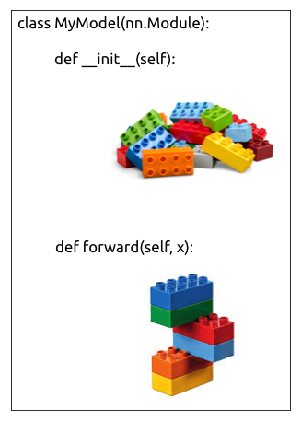

In [0]:
img = mpimg.imread(os.path.join(root_dir, 'model.png'))
plt.figure(figsize=(5,8))
plt.xticks([], [])
plt.yticks([], [])
plt.imshow(img)
plt.show()

In [0]:
N = 64       # batch size
D_in = 1000  # input dimension
H = 100      # hidden layer dimension
D_out = 10   # output dimension

In [0]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.w1 = nn.Linear(D_in, H)
        self.w2 = nn.Linear(H, D_out)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.w1(x)
        out = self.relu(out)
        out = self.w2(out)
        return out

In [0]:
# Get random tensors
x = torch.randn(N, D_in, dtype=torch.float)
y = torch.randn(N, D_out, dtype=torch.float)

# Training
model = SimpleNN()
num_epoch = 500
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
for t in range(num_epoch):
    # Forward
    y_pred = model(x)

    # Loss
    loss = loss_fn(y_pred, y)
    if (t+1) % 25 == 0:
      print(t+1, loss.item())

    # Back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

25 0.6137650609016418
50 0.35712096095085144
75 0.2002614289522171
100 0.10234956443309784
125 0.04639968276023865
150 0.01882879063487053
175 0.006991748698055744
200 0.002418942516669631
225 0.0007885858649387956
250 0.00024401933478657156
275 7.113632455002517e-05
300 1.9415680071688257e-05
325 5.015046099288156e-06
350 1.2378949350022594e-06
375 2.9767980436190555e-07
400 7.214892860929467e-08
425 1.832378160315784e-08
450 4.974504808075153e-09
475 1.4230639999723849e-09
500 4.142548803987012e-10


## CNN tutorial

Genre classification using GTZAN dataset which consists of 10 music genres.

### Data loader

In [0]:
with open(os.path.join(root_dir, 'specs.pkl'), 'rb') as f:
    specs = pickle.load(f)

class AudioFolder(data.Dataset):
    def __init__(self, specs, _set='train'):
        self._set = _set
        self.specs = specs
        list_fn = os.path.join(root_dir, 'filelist', _set+'.npy')
        self.filelist = np.load(list_fn)

    def __getitem__(self, index):
        fn = self.filelist[index]
        spec = self.get_spec(fn)
        label= self.get_label(fn)
        return spec.astype('float32'), label

    def get_spec(self, fn):
        spec = self.specs[fn]
        idx = int(np.floor(np.random.random(1) * (len(spec[0])-1366)))
        return spec[:, idx:idx+1366]

    def get_label(self, fn):
        genre = fn.split('/')[-1].split('.')[0]
        genres = {'blues': 0,
                  'classical': 1,
                  'country': 2,
                  'disco': 3,
                  'hiphop': 4,
                  'jazz': 5,
                  'metal': 6,
                  'pop': 7,
                  'reggae': 8,
                  'rock': 9}
        return genres[genre]

    def __len__(self):
        return len(self.filelist)


def get_audio_loader(specs, batch_size, _set='train', num_workers=0):
    data_loader = data.DataLoader(dataset=AudioFolder(specs, _set),
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers)
    return data_loader

train_loader = get_audio_loader(specs, 16, _set='train')
valid_loader = get_audio_loader(specs, 16, _set='validation')

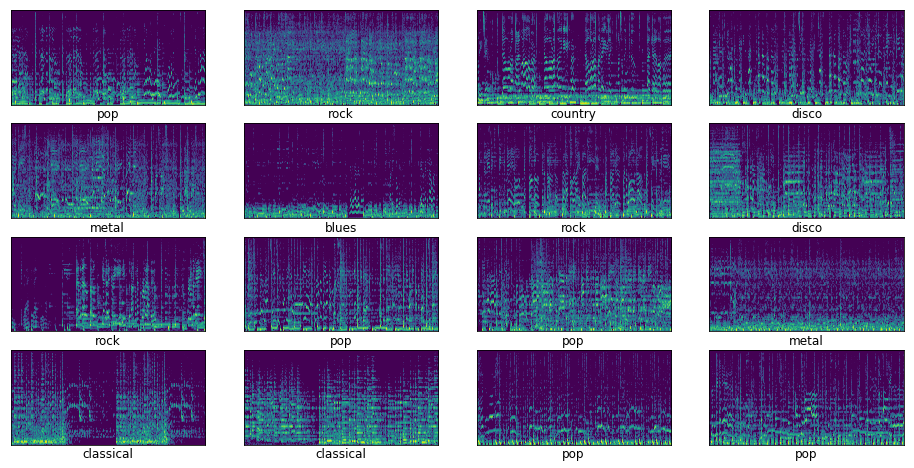

torch.Size([16, 96, 1366]) torch.Size([16])


In [0]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
iter_loader = iter(train_loader)
x, y = next(iter_loader)
plt.figure(figsize=(16,8))
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(x[i], origin='lower', aspect='auto')
  plt.xticks([], [])
  plt.yticks([], [])
  plt.title(genres[y[i]], y=-0.2)
plt.show()
print(x.shape, y.shape)

### Models

In [0]:
class CNN(nn.Module):
    def __init__(self, num_class=10):
        super(CNN, self).__init__()

        # init bn
        self.bn_init = nn.BatchNorm2d(1)

        # layer 1
        self.conv_1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn_1 = nn.BatchNorm2d(64)
        self.mp_1 = nn.MaxPool2d((2, 4))

        # layer 2
        self.conv_2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn_2 = nn.BatchNorm2d(128)
        self.mp_2 = nn.MaxPool2d((2, 4))

        # layer 3
        self.conv_3 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn_3 = nn.BatchNorm2d(128)
        self.mp_3 = nn.MaxPool2d((2, 4))

        # layer 4
        self.conv_4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn_4 = nn.BatchNorm2d(128)
        self.mp_4 = nn.MaxPool2d((3, 5))

        # layer 5
        self.conv_5 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn_5 = nn.BatchNorm2d(64)
        self.mp_5 = nn.MaxPool2d((4, 4))

        # classifier
        self.dense = nn.Linear(64, num_class)

    def forward(self, x):
        x = x.unsqueeze(1)

        # init bn
        x = self.bn_init(x)

        # layer 1
        x = self.mp_1(nn.ELU()(self.bn_1(self.conv_1(x))))

        # layer 2
        x = self.mp_2(nn.ELU()(self.bn_2(self.conv_2(x))))

        # layer 3
        x = self.mp_3(nn.ELU()(self.bn_3(self.conv_3(x))))

        # layer 4
        x = self.mp_4(nn.ELU()(self.bn_4(self.conv_4(x))))

        # layer 5
        x = self.mp_5(nn.ELU()(self.bn_5(self.conv_5(x))))

        # classifier
        x = x.view(x.size(0), -1)
        x = nn.Dropout(0.5)(x)
        logit = nn.Sigmoid()(self.dense(x))

        return logit

In [0]:
class ConvModule(nn.Module):
    def __init__(self, input_channels, output_channels, pool_size):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, 3, padding=1)
        self.bn = nn.BatchNorm2d(output_channels)
        self.mp = nn.MaxPool2d(pool_size)
    def forward(self, x):
        out = self.mp(nn.ELU()(self.bn(self.conv(x))))
        return out
        
class SimpleCNN(nn.Module):
    def __init__(self, num_class=10):
        super(SimpleCNN, self).__init__()
        # initial batch normalization
        self.bn_init = nn.BatchNorm2d(1)
        
        # stack convolutions
        channels = [1, 64, 128, 128, 128, 64]
        pools = [(2,4), (2,4), (2,4), (3,5), (4,4)]
        self.convs = nn.ModuleList([ConvModule(channels[i], channels[i+1], pools[i]) for i in range(5)])
        
        # classifier
        self.dense = nn.Linear(64, num_class)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        
        # init bn
        x = self.bn_init(x)
        
        # stack convolutions
        for layer in self.convs:
            x = layer(x)
            
        # classifier
        x = x.view(x.size(0), -1)
        x = nn.Dropout(0.5)(x)
        logit = nn.Sigmoid()(self.dense(x))
        
        return logit
        

In [0]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # Your layers here
        
    def forward(self, x):
        # Build your layers
        
        return x
        

### Training

In [0]:
model = CNN()
#model = SimpleCNN()
#model = MyCNN()
model = model.cuda() # to use GPUs
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
reconst_loss = nn.CrossEntropyLoss()

In [0]:
start_t = time.time()
num_epoch = 10
for epoch in range(num_epoch):
    model.train()
    ctr = 0
    for x, y in train_loader:
        ctr += 1
        # to GPU
        x = x.cuda()
        y = y.cuda()
        
        # predict
        prd = model(x)
        loss = reconst_loss(prd, y)
        
        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print log
        if ctr % 15 == 0:
            print("[%s] Epoch [%d/%d] Iter [%d/%d] train loss: %.4f Elapsed: %s" %
                 (datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                 epoch+1, num_epoch, ctr, len(train_loader), loss.item(),
                 datetime.timedelta(seconds=time.time()-start_t)))
    model.eval()
    ctr = 0
    prd_array = []
    gt_array = []
    for x, y in valid_loader:
        ctr += 1
        # to GPU
        x = x.cuda()
        y = y.cuda()
        
        # predict
        prd = model(x)
        loss = reconst_loss(prd, y)
        
        # append
        prd = prd.detach().cpu()
        y = y.detach().cpu()
        for _p in prd:
            prd_array.append(int(_p.argmax()))
        for _y in y:
            gt_array.append(int(_y))
        
        # print log
        if ctr % 7 == 0:
            print("[%s] Epoch [%d/%d] Iter [%d/%d] validation loss: %.4f Elapsed: %s" %
                 (datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                 epoch+1, num_epoch, ctr, len(valid_loader), loss.item(),
                 datetime.timedelta(seconds=time.time()-start_t)))
                             
    print("accuracy: %.4f" % sklearn.metrics.accuracy_score(gt_array, prd_array)) 
            
        
        

[2019-05-21 21:32:57] Epoch [1/10] Iter [15/30] train loss: 2.2279 Elapsed: 0:00:01.817750
[2019-05-21 21:32:59] Epoch [1/10] Iter [30/30] train loss: 2.1825 Elapsed: 0:00:03.473794
[2019-05-21 21:32:59] Epoch [1/10] Iter [7/14] validation loss: 2.2902 Elapsed: 0:00:03.774184
[2019-05-21 21:33:00] Epoch [1/10] Iter [14/14] validation loss: 2.3058 Elapsed: 0:00:04.035307
accuracy: 0.1943
[2019-05-21 21:33:01] Epoch [2/10] Iter [15/30] train loss: 2.2337 Elapsed: 0:00:05.709659
[2019-05-21 21:33:03] Epoch [2/10] Iter [30/30] train loss: 2.1118 Elapsed: 0:00:07.372473
[2019-05-21 21:33:03] Epoch [2/10] Iter [7/14] validation loss: 2.2045 Elapsed: 0:00:07.670340
[2019-05-21 21:33:04] Epoch [2/10] Iter [14/14] validation loss: 2.3050 Elapsed: 0:00:07.933444
accuracy: 0.2607
[2019-05-21 21:33:05] Epoch [3/10] Iter [15/30] train loss: 2.0979 Elapsed: 0:00:09.614022
[2019-05-21 21:33:07] Epoch [3/10] Iter [30/30] train loss: 2.1584 Elapsed: 0:00:11.283307
[2019-05-21 21:33:07] Epoch [3/10] Ite

### Evaluation

accuracy: 0.3923


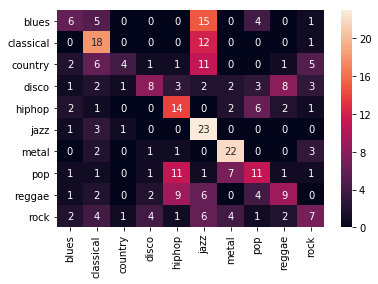

In [0]:
test_loader = get_audio_loader(specs, 16, _set='test')
model.eval()
prd_array = []
gt_array = []
for x, y in test_loader:
    # to GPU
    x = x.cuda()
    y = y.cuda()

    # predict
    prd = model(x)
    loss = reconst_loss(prd, y)

    # append
    prd = prd.detach().cpu()
    y = y.detach().cpu()
    for _p in prd:
        prd_array.append(int(_p.argmax()))
    for _y in y:
        gt_array.append(int(_y))

print("accuracy: %.4f" % sklearn.metrics.accuracy_score(gt_array, prd_array)) 
plt.figure()
cm = sklearn.metrics.confusion_matrix(gt_array, prd_array)
seaborn.heatmap(cm, annot=True, xticklabels=genres, yticklabels=genres)
